core           INFO 	Loading laps for Qatar Grand Prix - Race [v2.1.11]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['14', '7', '55', '31', '10', '33', '4', '22', '99', '47', '3', '77', '63', '5', '9', '18', '11', '16', '44', '6']


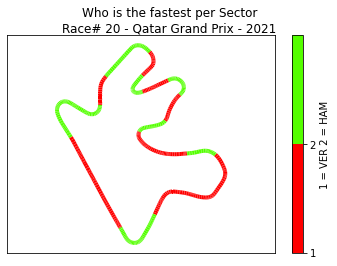

In [107]:
import fastf1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm
import numpy as np
import pandas as pd
#
fastf1.Cache.enable_cache('cache')  # replace with your cache directory
#
##  functions below will be called one by one from main
#
def get_race(RaceNameorNum):
    session = fastf1.get_session(2021, RaceNameorNum, 'R')
    return session

def did_finish(session,d1,d2):
    drv=session.get_driver(d1)
    if drv.dnf:
        return False
    else:
        drv=session.get_driver(d2)
        if drv.dnf:
            return False
        else:
            return True

def get_laps(session):
    laps=session.load_laps(with_telemetry=True)
    return laps

def get_driver_laps(laps, driver):
    lps=laps.pick_driver(driver)
    return lps

def get_tel_data(drvlaps, driver):
    tel=pd.DataFrame()
    tmp=pd.DataFrame()
    x=1
#   print("before lapping")
    for lap in drvlaps.iterlaps():
#       print("lap " +str(x))
        x=x+1
        tmp=lap[1].get_telemetry().add_distance()
        #
        # some columns have to be added from the lap itself
        #
        tmp['LapNumber']=lap[1]['LapNumber']
        tmp['PitOutTime']=lap[1]['PitOutTime']
        tmp['PitInTime']=lap[1]['PitInTime']
        tmp['IsAccurate']=lap[1]['IsAccurate']
        tel=tel.append(tmp)
    #
    # Adding the driver
    #
#   print("adding driver")
    tel['Driver']=driver
    #
    # Keeping the lines needed - PitIn- and OutTime just to double check 
    #
#   print("selecting columns")
    tel=tel[['LapNumber','Driver','Distance','Speed','PitInTime','PitOutTime','IsAccurate','X','Y']]
    #
    # Now dropping the lines that are inaccurate by keeping the accurate ones :-)
    #
    tel=tel[tel.IsAccurate]
    return tel
   
def define_minisecs(tel,num_minisecs):
#   print("dropped lines")
    #
    # adding the minisectors
    #
    # What is the total distance of a lap?
    total_distance = max(tel['Distance'])
    sector_length = total_distance/num_minisecs
    #
    # now the sectors have to be assigned to both dataframes
    # based on the mentioned distance in each row
    # so 'looping' over all rows so to speak
    #
#   print("adding minisectors")
    tel['MiniSector']=tel['Distance'].apply(
        lambda dist: (
            int((dist//sector_length)+1))
    )
#   print("ready")
    return tel

def calc_join_tracks(trackA, trackB):
    trackA_avg_speed = trackA.groupby(['MiniSector'])['Speed'].mean().reset_index()
    trackB_avg_speed = trackB.groupby(['MiniSector'])['Speed'].mean().reset_index()
    sect_avg_speed = trackA_avg_speed.join(trackB_avg_speed.set_index('MiniSector'),
                                   on='MiniSector', lsuffix='_ver', rsuffix='_ham')
    #
    # Now compare the speeds per minisector and assign a new column to contain the appropriate values:
    # 1 = Verstappen is fastest and 2 = Hamilton is fastest
    sect_avg_speed['fastest']=np.where(sect_avg_speed['Speed_ver']>sect_avg_speed['Speed_ham'],1,2)
    return sect_avg_speed

def get_x_y_mini(ver_tel):
    #
    # get one (1) lap from one of the DFs from Ham or Ver containing the x-y position data
    #
    track=ver_tel.loc[ver_tel['LapNumber']==ver_tel['LapNumber'].min()]
    # get rid of columns not needed
    track=track[['X', 'Y','MiniSector']]
    return track

def getFastest(i,theFastest):
    i=i-1
    return theFastest[i]

def set_fastest(sect_avg_speed, track):
    #
    # Make a list of the fastest values
    #
    theFastest=sect_avg_speed['fastest']
    #
    # Small function to get the right value for fastest
    #
    track['Fastest']=track['MiniSector'].apply(
        lambda ms:(
            getFastest(ms,theFastest)))
    return track

def make_chart(session,track,race):
#
# Now - get ready to plot
#

    x = np.array(track['X'].values)
    y = np.array(track['Y'].values)

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    fastest = track['Fastest'].to_numpy().astype(float)

    cmap = cm.get_cmap('prism', 2)
    lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
    #lc_comp = LineCollection(segments, norm=plt.Normalize(), cmap=cmap)
    lc_comp.set_array(fastest)
    lc_comp.set_linewidth(4)

    ## create the plot

    plt.gca().add_collection(lc_comp)
    plt.axis('equal')
    plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

    title = plt.suptitle(
        f"Who is the fastest per Sector\n"
        f"Race# {r} - {session.weekend.name} - {session.weekend.year}"
    )
    ## add a color bar

    cbar = plt.colorbar(mappable=lc_comp, label='1 = VER 2 = HAM', boundaries=np.arange(1, 3))
    cbar.set_ticks(np.arange(1,3))
    cbar.set_ticklabels(np.arange(1,3))

    if race<10:
        racenum='0'+str(race)
    else:
        racenum=str(race)
        
    plt.savefig(f"{racenum}_{session.weekend.name}_{session.weekend.year}.png", facecolor='w')
    plt.show()
    
if __name__ == "__main__":
    
    for r in range (20,21):

        sess=get_race(r)
        if did_finish(sess,'VER','HAM'):
            laps=get_laps(sess)
            ver_laps=get_driver_laps(laps,'VER')
            ham_laps=get_driver_laps(laps,'HAM')
            ver_tel=get_tel_data(ver_laps, 'VER')
            ham_tel=get_tel_data(ham_laps, 'HAM')
            if len(ver_tel.index) >0 and len(ham_tel.index>0):
                ver_tel=define_minisecs(ver_tel,25)
                ham_tel=define_minisecs(ham_tel,25)
                sect_avg_speed =calc_join_tracks(ver_tel,ham_tel)
                track=get_x_y_mini(ver_tel)
                track=set_fastest(sect_avg_speed,track)
                make_chart(sess,track,r)

